In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.random_projection import GaussianRandomProjection
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import pickle

In [2]:
def plot_confusion_matrix(cm, dataset_name):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='viridis')
    plt.title(f'Confusion Matrix: {dataset_name}')
    plt.show()

In [3]:
models_base = {
    "rf": {
        "model": RandomForestClassifier(n_estimators=1000, random_state=42, class_weight='balanced'),
        "name": "Random Forest Classifier",
        "file": "models\\rf_base.pkl"
    },
    "mlp": {
        "model": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
        "name": "MLP Classifier",
        "file": "models\\mlp_base.pkl"
    },
    "gbm": {
        "model": GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, random_state=42),
        "name": "Gradient Boosting Classifier",
        "file": "models\\gbm_base.pkl"
    }
}

models_scaled = {
    "rf": {
        "model": RandomForestClassifier(n_estimators=1000, random_state=42, class_weight='balanced'),
        "name": "Random Forest Classifier",
        "file": "models\\rf_scaled.pkl"
    },
    "mlp": {
        "model": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
        "name": "MLP Classifier",
        "file": "models\\mlp_scaled.pkl"
    },
    "gbm": {
        "model": GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, random_state=42),
        "name": "Gradient Boosting Classifier",
        "file": "models\\gbm_scaled.pkl"
    }
}

In [4]:
df = pd.read_csv("features.csv")

C:\Users\abhishek\AppData\Local\Temp\ipykernel_10140\4158748275.py:1: DtypeWarning: Columns (6,8,10,14,21,22,24,28,29,41,46,49,50,52,53,57,64,65,66,67,68,69,70,71,72,75,76,78,80,81,82,83,84,85,87,91,94,96,98,99,100,102,103,104,105,106,107,108,109,120,122,129,132,137,139,144,147,150,154,156,157,159,162,163,165,167,168,169,172,174,175,178,183,184,186,187,195,197,200,202,210,220,221,223,232,234,236,237,238,239,242,244,246,253,256,257,258,259,260,262,263,272,273,274,284,288,289,290,292,299,301,302,304,305,308,309,311,316,317,324,325,326,327,328,337,338,340,345,354,359,364,366,368,370,371,372,374,375,376,385,386,387,388,391,392,394,395,396,398,400,407,408,409,410,412,413,414,419,422,423,424,426,427,428,432,435,436,439,440,442,444,446,447,448,449,457,458,459,463,464,466,467,479,480,483,484,489,496,499,500,501,502,504,507,512,515,516,521,523,524,525,527,529,532,534,536,537,538,539,540,542,543,544,545,546,551,552,564,567,568,574,576,577,580,581,582,583,585,586,589,590,591,592,593,594,595,597,5

In [5]:
def handle_missing_values(data, drop=False, thresh=None):
    # df_missing = df.copy()
    if drop: df_missing = data.dropna(axis=1, thresh=int(thresh * len(data)))
    else: df_missing = data.copy()
    
    df_missing.fillna(-1, inplace=True)
    return df_missing

def encode_features(data, encoding):
    string_columns = df_missing.select_dtypes(include='object').columns
    print("Columns with string values:", string_columns)
    
    if encoding == 'label':
        label_encoder = LabelEncoder()
        df = data.copy()

        for col in string_columns:
            df[col] = df[col].astype(str)

        for col in string_columns:
            df[col] = label_encoder.fit_transform(df[col])

        return df
    elif encoding == "one-hot":
        return pd.get_dummies(data, columns=string_columns)
    else:
        return None

df_missing = handle_missing_values(df)
df_encoded = encode_features(df_missing, 'one-hot')

Columns with string values: Index(['283', '888', '790', '202', '6', '892', '884', '42', '523', '978',
       ...
       '95', '82', '875', '877', '239', '760', '489', '428', '183', '200'],
      dtype='object', length=426)


In [6]:
df_label_1 = df_encoded[df_encoded['target'] == 1]
df_label_0 = df_encoded[df_encoded['target'] == 0].sample(n=len(df_label_1), random_state=42) 

df_balanced = pd.concat([df_label_1, df_label_0]).sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
def run_models(models, X, y, *, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=42)

    for model_type in models:
        if model_type == "mlp":
            scaler = StandardScaler()
            X_train_model = scaler.fit_transform(X_train)
            X_test_model = scaler.transform(X_test)

            y_train_model = y_train
            y_test_model = y_test
        else:
            X_train_model = X_train
            X_test_model = X_test

            y_train_model = y_train
            y_test_model = y_test

        models[model_type]['model'].fit(X_train_model, y_train_model)

        y_pred = models[model_type]['model'].predict(X_test_model)
        print(f"{models[model_type]['name']} Performance:")
        print(f"\tTraining Accuracy: {accuracy_score(y_train_model, models[model_type]['model'].predict(X_train_model)) * 100:.2f}%")
        print(f"\tTesting Accuracy: {accuracy_score(y_test_model, y_pred) * 100:.2f}%")
        print(classification_report(y_test_model, y_pred))

        plot_confusion_matrix(confusion_matrix(y_test_model, y_pred), models[model_type]['name'])

        with open(models[model_type]['file'], 'wb') as file:
            pickle.dump(models[model_type]['model'], file)

Random Forest Classifier Performance:
	Training Accuracy: 99.51%
	Testing Accuracy: 66.54%
              precision    recall  f1-score   support

           0       0.68      0.62      0.65      4000
           1       0.65      0.71      0.68      4000

    accuracy                           0.67      8000
   macro avg       0.67      0.67      0.66      8000
weighted avg       0.67      0.67      0.66      8000



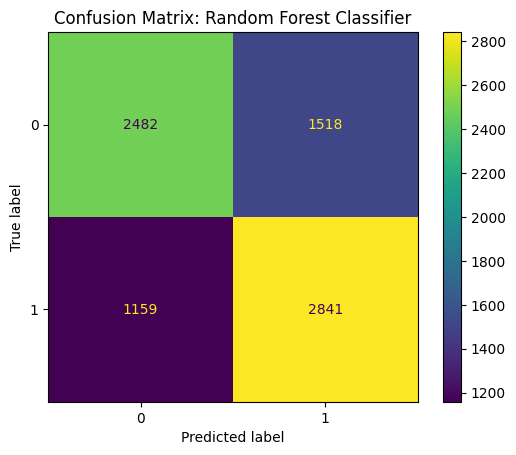

MLP Classifier Performance:
	Training Accuracy: 51.28%
	Testing Accuracy: 49.58%
              precision    recall  f1-score   support

           0       0.50      0.64      0.56      4000
           1       0.49      0.35      0.41      4000

    accuracy                           0.50      8000
   macro avg       0.50      0.50      0.49      8000
weighted avg       0.50      0.50      0.49      8000



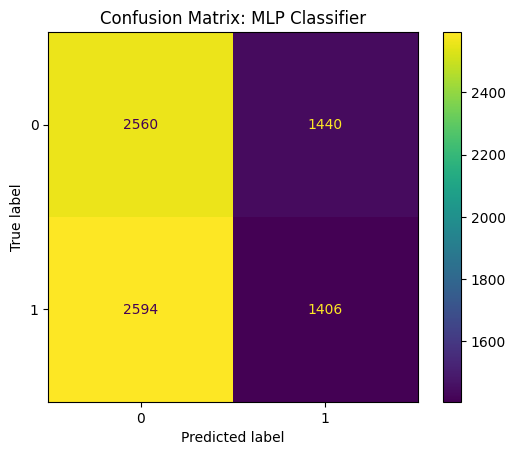

Gradient Boosting Classifier Performance:
	Training Accuracy: 71.31%
	Testing Accuracy: 58.60%
              precision    recall  f1-score   support

           0       0.59      0.59      0.59      4000
           1       0.59      0.58      0.59      4000

    accuracy                           0.59      8000
   macro avg       0.59      0.59      0.59      8000
weighted avg       0.59      0.59      0.59      8000



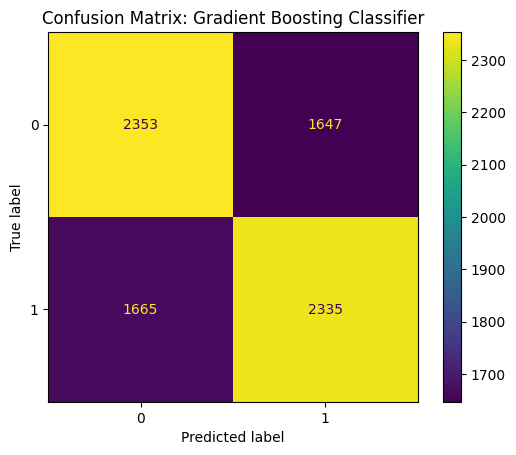

In [10]:
X = df_balanced.drop(columns=['target', 'visitorid'], errors='ignore')
y = df_balanced['target']

smote = SMOTE(random_state=42)
undersample = RandomUnderSampler(random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('smote', smote),
    ('undersample', undersample)
])

# Apply the pipeline to the training data
X_resampled, y_resampled = pipeline.fit_resample(X, y)

run_models(models_base, X, y, test_size=0.2)

In [9]:
jl_transform = GaussianRandomProjection(n_components=200)
X_scaled = jl_transform.fit_transform(X)

Random Forest Classifier Performance:
	Training Accuracy: 99.51%
	Testing Accuracy: 61.69%
              precision    recall  f1-score   support

           0       0.63      0.57      0.60      4000
           1       0.61      0.66      0.63      4000

    accuracy                           0.62      8000
   macro avg       0.62      0.62      0.62      8000
weighted avg       0.62      0.62      0.62      8000



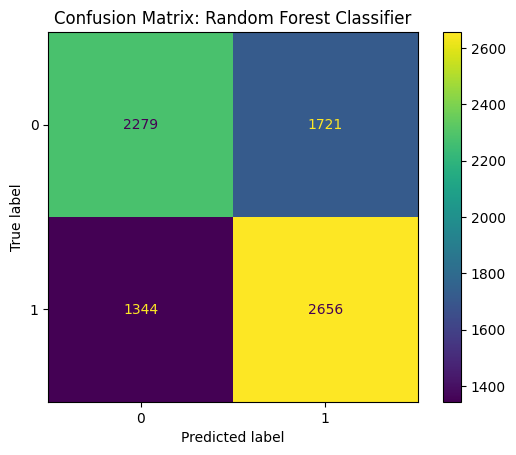

MLP Classifier Performance:
	Training Accuracy: 57.04%
	Testing Accuracy: 56.62%
              precision    recall  f1-score   support

           0       0.57      0.53      0.55      4000
           1       0.56      0.60      0.58      4000

    accuracy                           0.57      8000
   macro avg       0.57      0.57      0.57      8000
weighted avg       0.57      0.57      0.57      8000



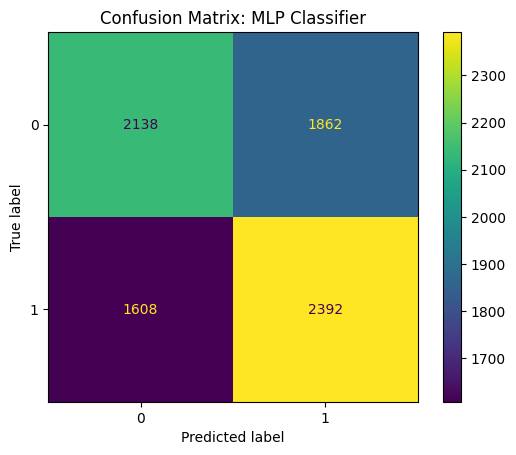

Gradient Boosting Classifier Performance:
	Training Accuracy: 63.43%
	Testing Accuracy: 58.98%
              precision    recall  f1-score   support

           0       0.59      0.59      0.59      4000
           1       0.59      0.59      0.59      4000

    accuracy                           0.59      8000
   macro avg       0.59      0.59      0.59      8000
weighted avg       0.59      0.59      0.59      8000



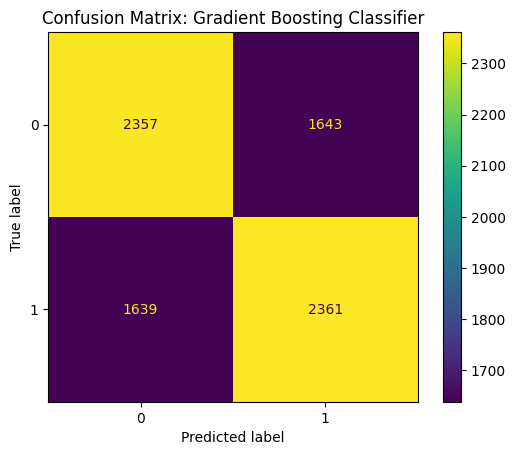

In [8]:
run_models(models_scaled, X_scaled, y, test_size=0.2)

In [11]:
X.shape, X_scaled.shape

((40000, 1450), (40000, 200))